In [1]:
clean_up = True
%run stdPackages.ipynb

The file _gams_py_gdb0.gdx is still active and was not deleted.
The file _gams_py_gdb1.gdx is still active and was not deleted.
The file _gams_py_gdb4.gdx is still active and was not deleted.


In [2]:
import math, dash
import plotly.express as px
from plotly.subplots import make_subplots

# Simulations in partial equilibrium

In [3]:
ws = gams.GamsWorkspace(working_directory=d['work']) # specify where you want to run the GAMS models from (here the repository referred to in d['work'])
with open(f"{d['data']}\\APi","rb") as file:
    P = pickle.load(file)
P.write();

Define a standardized report for a shock in this module as follows:
* Add a database with target values for an exogenous variable. Extract data on ```qD, pD, p``` in a solution loop.
* Plot time series for durables/non-durables on (sector, goods levels).
* Plot time series for durables/non-durables on goods levels.
* Plot time series for equilibrium and effective input prices. 

In [4]:
def stdPlot(df, c, title):
    nplots,nrows = len(c), math.ceil(len(c)/2)
    fig, axes = plt.subplots(nrows, min(nplots,2), figsize=(12,(3*nrows)));
    for i in range(nplots):
        ax = plt.subplot(nrows,min(nplots,2),i+1)
        df.xs(c[i], level = c.names).plot(ax=ax, legend=False);
        ax.set_title(c[i])
    fig.legend(df.columns,ncol=5,bbox_to_anchor=(.7, 0),frameon=True)
    fig.suptitle(title,fontsize=15)
    fig.tight_layout()
    return fig

In [5]:
def stdPlots(m,P):
    stdPlot(adj.rc_pd(m.out_db.get('sol_qD_shock'), P.get('dur')).unstack('l1'), P.get('dur'), "qD, durables")
    stdPlot(adj.rc_pd(m.out_db.get('sol_pD_shock'), ('and', [P.get('dur'), P.get('txE')])).unstack('l1'), P.get('dur'), "pD, durable")
    sn = adj.rc_pd(P.get('input'), ('not', P.get('inv')))
    stdPlot(adj.rc_pd(m.out_db.get('sol_qD_shock'), ('and', [sn, P.get('txE')])).unstack('l1'), sn, "qD, non-durables")
    stdPlot(adj.rc_pd(m.out_db.get('sol_p_shock'), ('and', [P.get('output_n'), P.get('txE')])).unstack('l1'), P.get('output_n'), "p, non-durables")
    stdPlot(adj.rc_pd(m.out_db.get('sol_pD_shock'), ('and', [P.get('output'), P.get('txE')])).unstack('l1'), P.get('output'), "pD, non-durables")

#### 1. Increase an input tax

Expected outcome: In partial equilibrium the supply from the sectors is kept constant. Thus, increasing the tax on a specific input, the production will substitute towards cheaper inputs. Specifically, increasing the tax on a non-durable as ```a```:
* Substitution towards durables yields an associated increase in the shadow cost of said durable.
* Transition costs makes both ```a``` and ```b``` more expensive in the short run. Over time, the prices decrease towards a higher level than before (due to the permanent higher cost of ```a```).
* The demand for other non-durables than the more expensive ```a``` increases permanently. The increase is (for the most part) largest in the short run, because of the gradual transition in the use of durables.

*i. Set up target database:*

In [6]:
dbT = GpyDB(**{'name': 'TaxShock'})
dbT['tauD'] = pd.Series(1, index = pd.MultiIndex.from_product([P.get('t'), P.get('s'), pd.Index(['a'], name = 'n')]), name = 'tauD')
extractSol = {k:None for k in ('qD','pD','p')}

*ii. Solve:*

In [7]:
m_a, cp_a = P.sneakySolve(dbT, ws = ws, loop_kwargs = {'extractSol': extractSol, 'n': 5}, **{'cns': 'CONOPT4'})

*iii. Plot:*

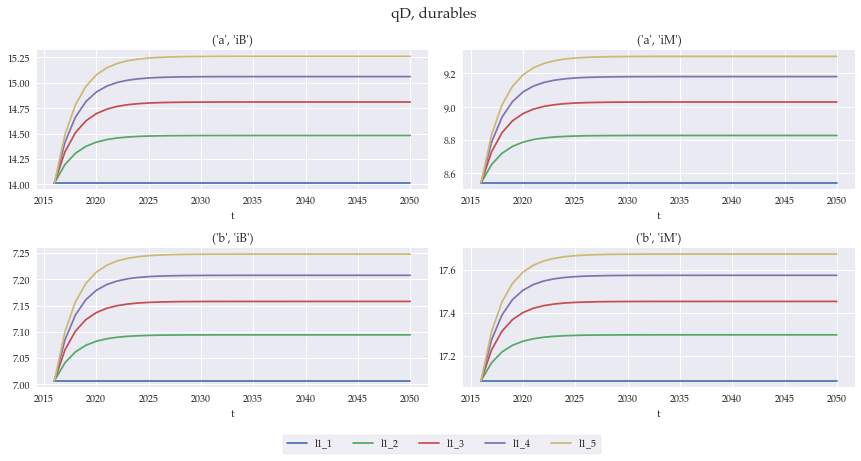

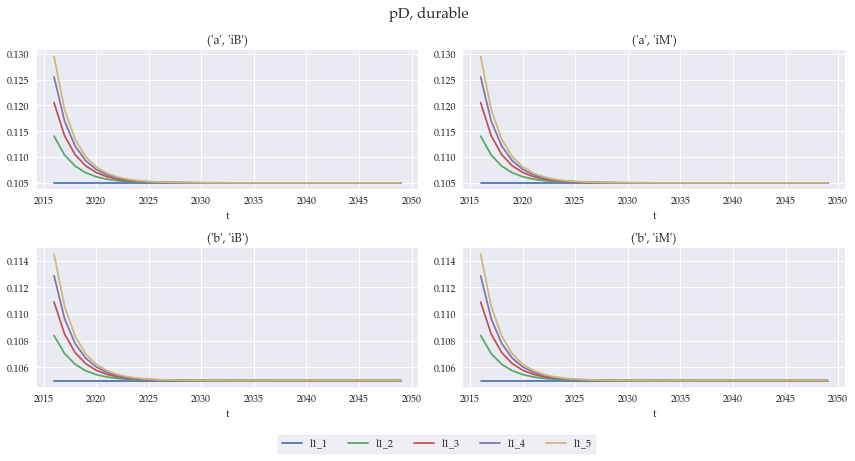

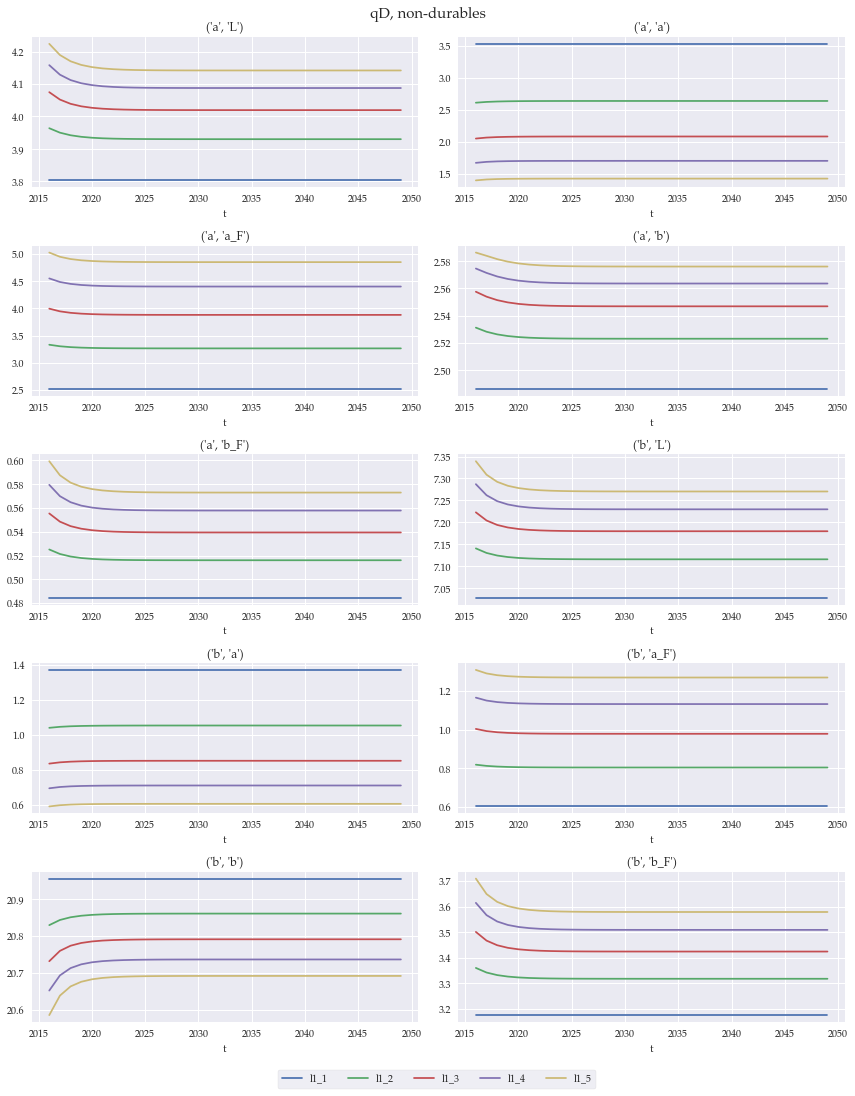

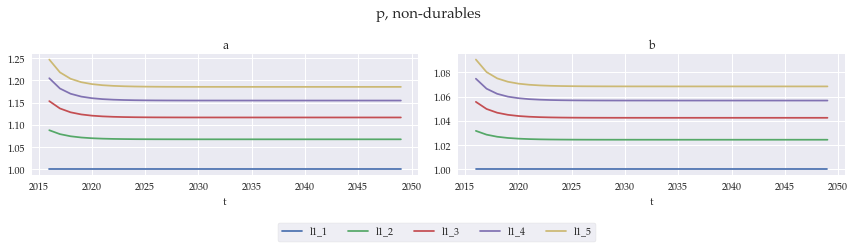

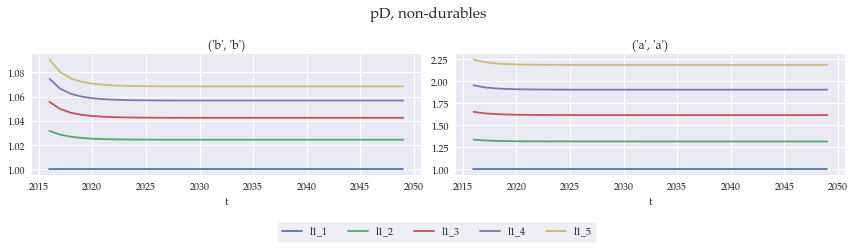

In [8]:
stdPlots(m_a,P)

#### 2. Increase in output from both sectors:

Expected outcome:
* Durables increase gradually over time. During the adjustment, the shadow cost of durables increase.
* Transition costs increase the price on ```a, b``` in the short run. In the long run, prices converge towards the same original price level though.
* Demand for ```a,b``` might increase/decrease in the short run (scale of production increases, but so is relative price). In the long run, demand increases.
* Demand for ```a_F,b_F``` increase sharply initially (scale of production increases + relative price lower compared to domestic market). In the long run, demand is still higher, but less so than in the short run. A similar story for demand for ```L``` (albeit a smaller initial increase).

*i. Set up target database:*

In [9]:
dbT = GpyDB(**{'name': 'SupplyShock'})
dbT['qS'] = P.get('qS')*1.2
extractSol = {k:None for k in ('qD','pD','p')}

*ii. Solve:*

In [10]:
m_s, cp_s = P.sneakySolve(dbT, ws = ws, loop_kwargs = {'extractSol': extractSol, 'n': 5}, **{'cns': 'CONOPT4'})

*iii. Plot.*

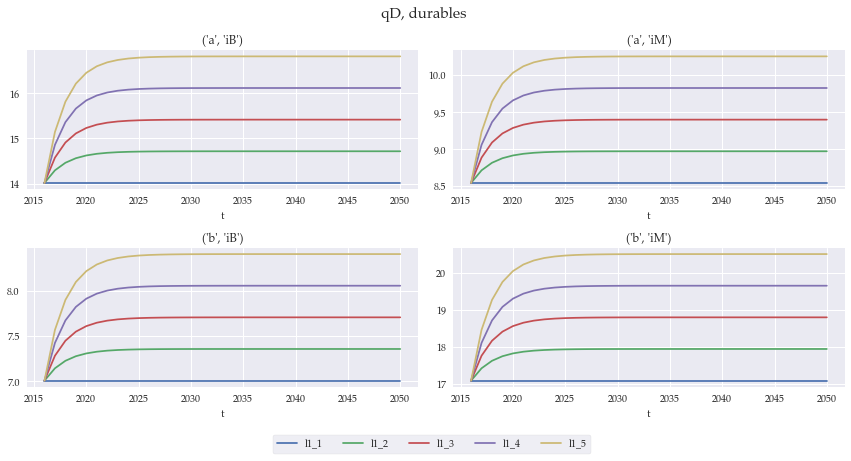

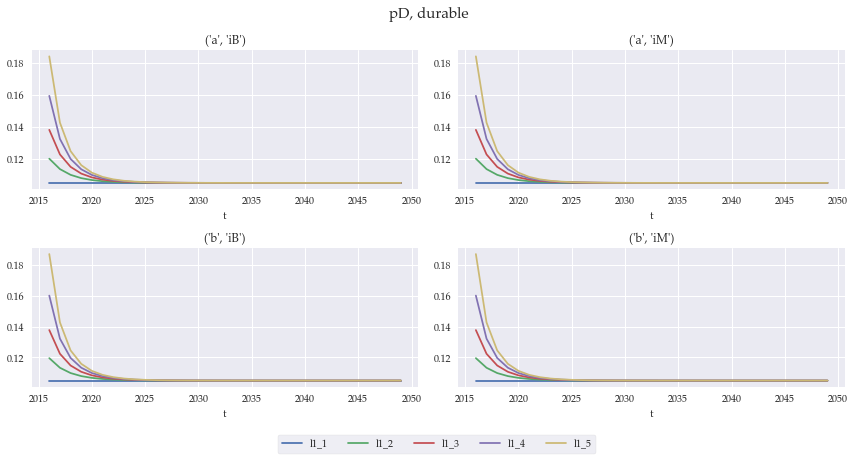

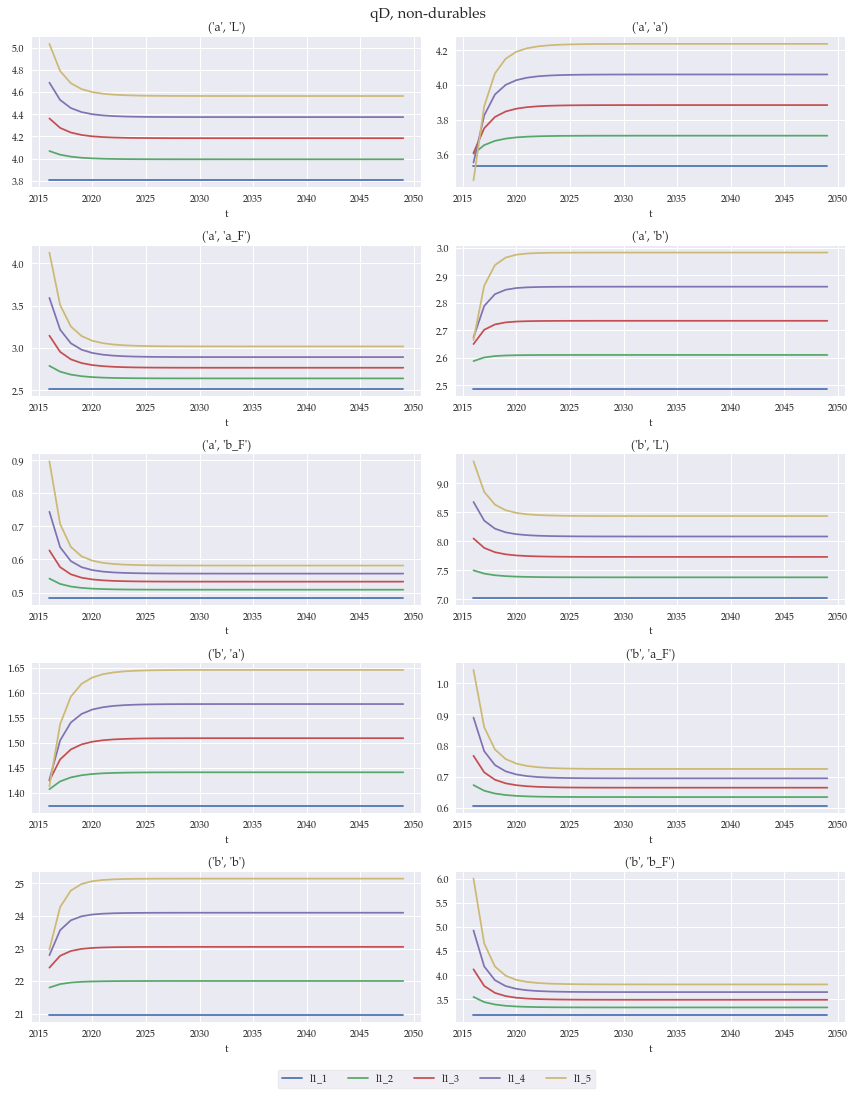

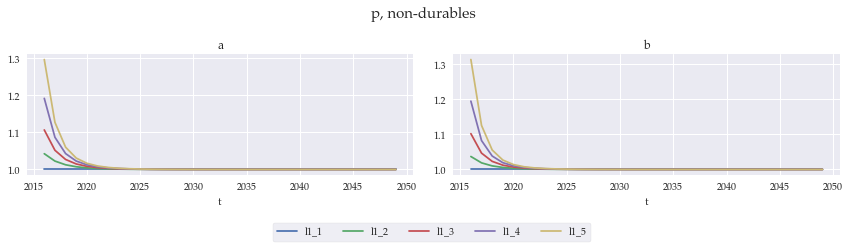

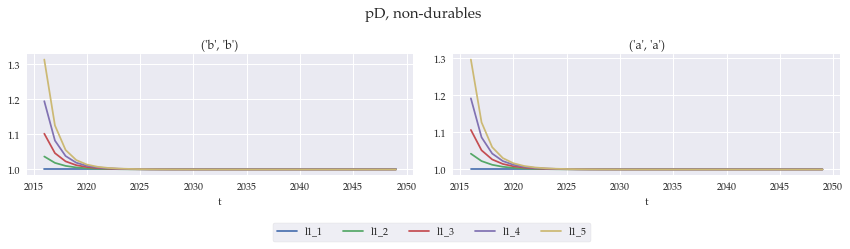

In [11]:
stdPlots(m_s,P)

#### 3. A drop in initial capital

Expected outcome: The model converges on the original solution. As the level of supply is fixed, the transition dynamics follows:
* Durables gradually increase; associated prices are higher in the transition.
* Due to transition costs, the prices on ```a, b``` increase in the short run. Thus, the demand for ```a,b``` decrease in the short run. 
* To keep the level of supply fixed, the use of non-durables that are not ```a,b``` (L and foreign goods) increases.

*i. Set up target database:*

In [12]:
dbT = GpyDB(**{'name': 'TaxShock'})
dbT['qD'] = adj.rc_pd(P.get('qD'), ('and', [P.get('dur'),P.get('t0')])) * 0.75
extractSol = {k:None for k in ('qD','pD','p')}

*ii. Solve:*

In [13]:
m_c, cp_c = P.sneakySolve(dbT, ws = ws, loop_kwargs = {'extractSol': extractSol, 'n': 5}, **{'cns': 'CONOPT4'})

*iii. Plot:*

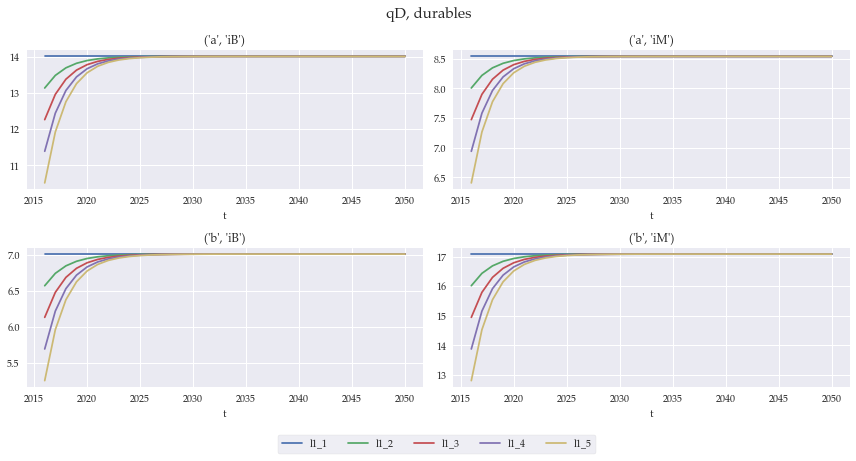

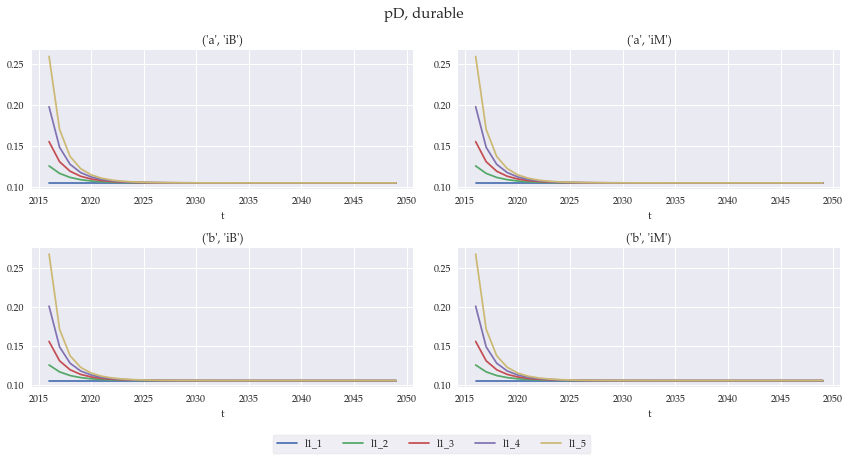

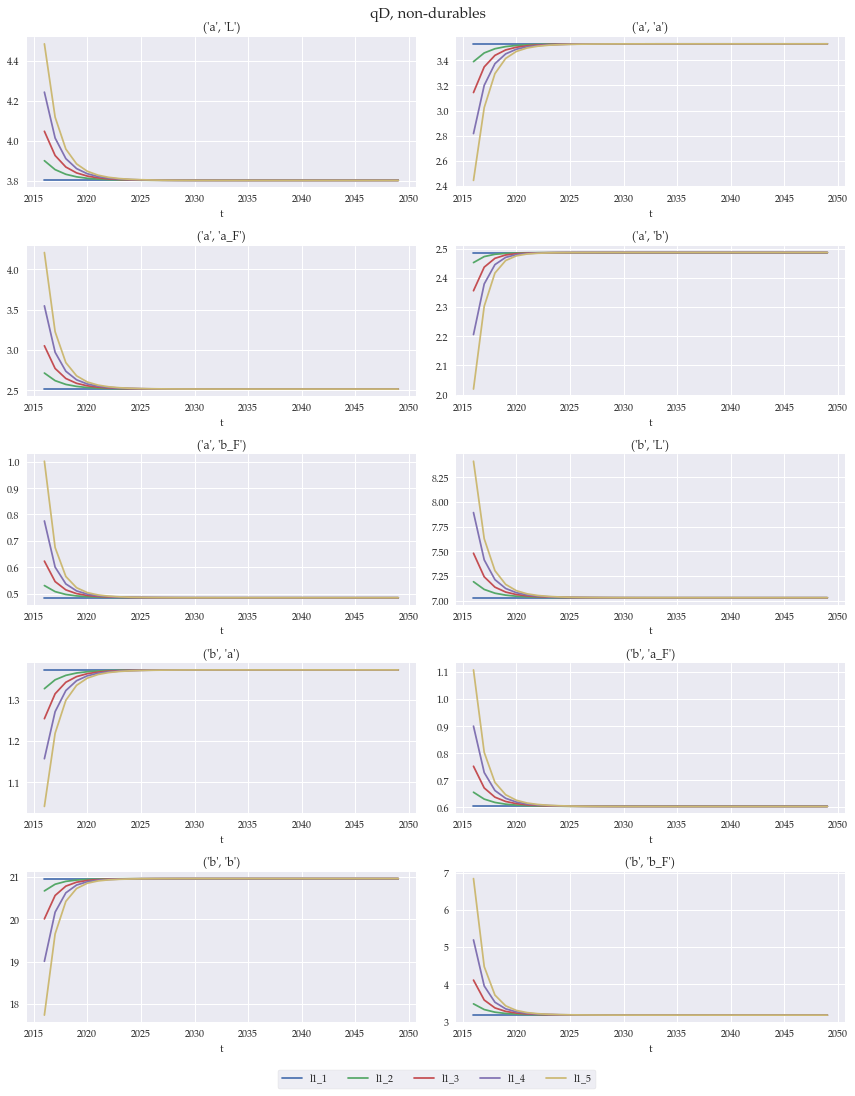

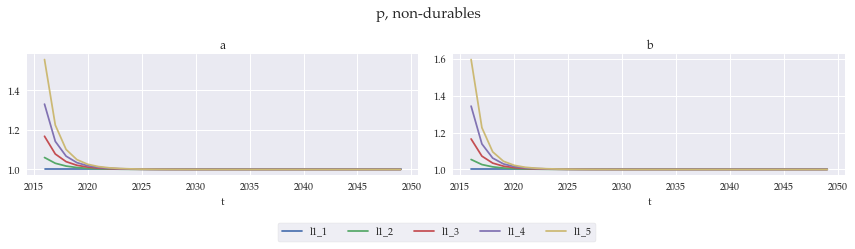

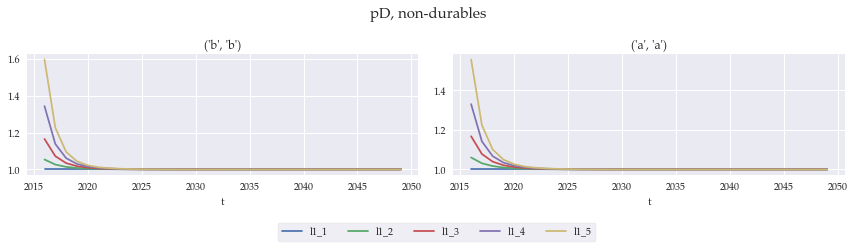

In [14]:
stdPlots(m_c,P)

#### 4. An increase in initial capital

*i. Set up target database:*

In [15]:
dbT = GpyDB(**{'name': 'TaxShock'})
dbT['qD'] = adj.rc_pd(P.get('qD'), ('and', [P.get('dur'),P.get('t0')])) * 1.25
extractSol = {k:None for k in ('qD','pD','p')}

*ii. Solve:*

In [16]:
m_c, cp_c = P.sneakySolve(dbT, ws = ws, loop_kwargs = {'extractSol': extractSol, 'n': 5}, **{'cns': 'CONOPT4'})

*iii. Plot:*

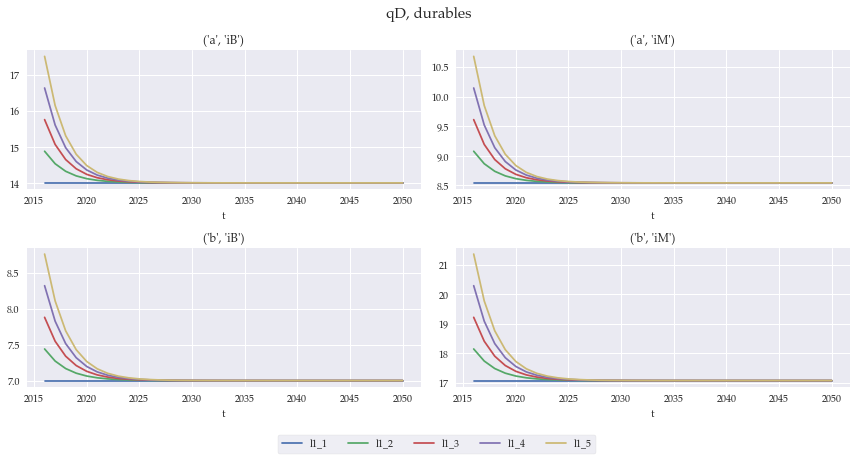

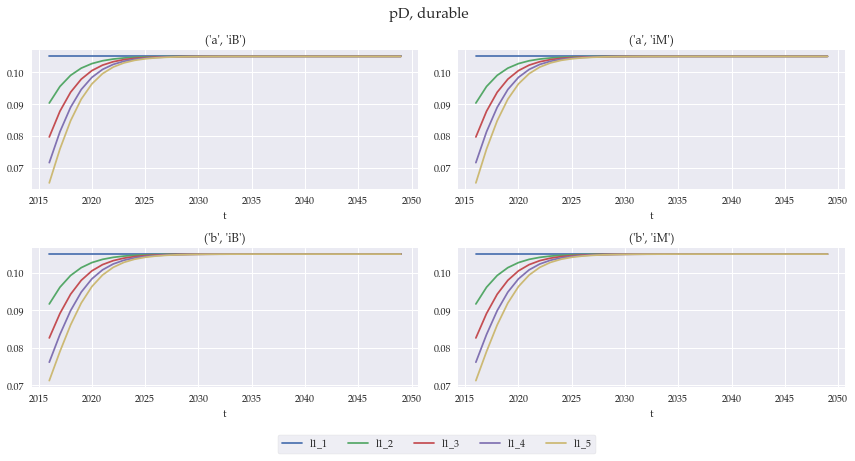

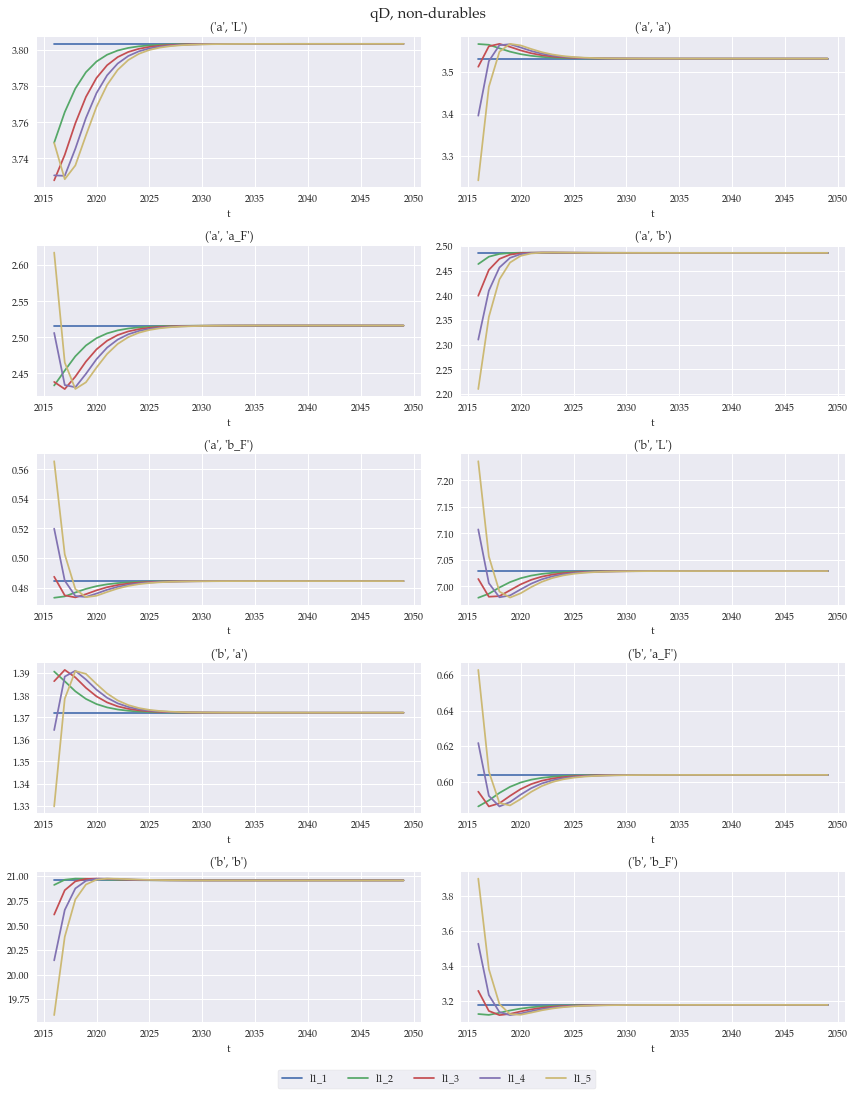

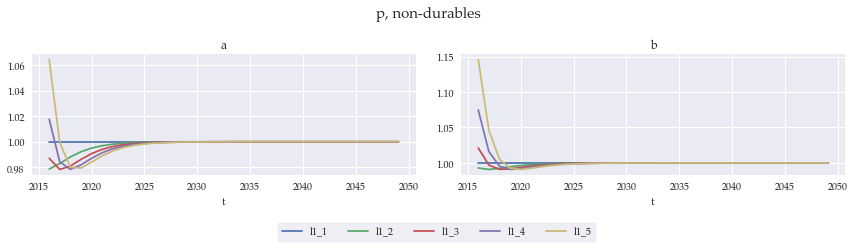

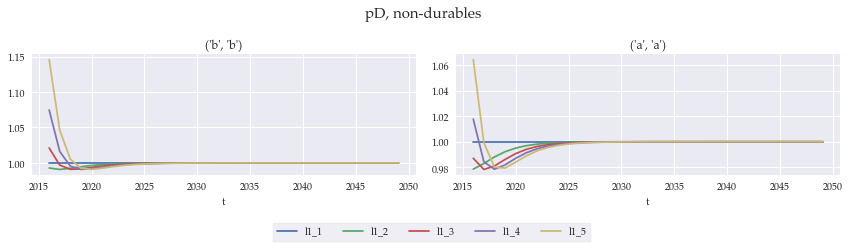

In [17]:
stdPlots(m_c,P)

#### 5. A drop in supply

*i. Set up target database:*

In [18]:
dbT = GpyDB(**{'name': 'SupplyShock2'})
dbT['qS'] = P.get('qS')*0.8
extractSol = {k:None for k in ('qD','pD','p')}

*ii. Solve:*

In [19]:
m_s, cp_s = P.sneakySolve(dbT, ws = ws, loop_kwargs = {'extractSol': extractSol, 'n': 5}, **{'cns': 'CONOPT4'})

*iii. Plot:*

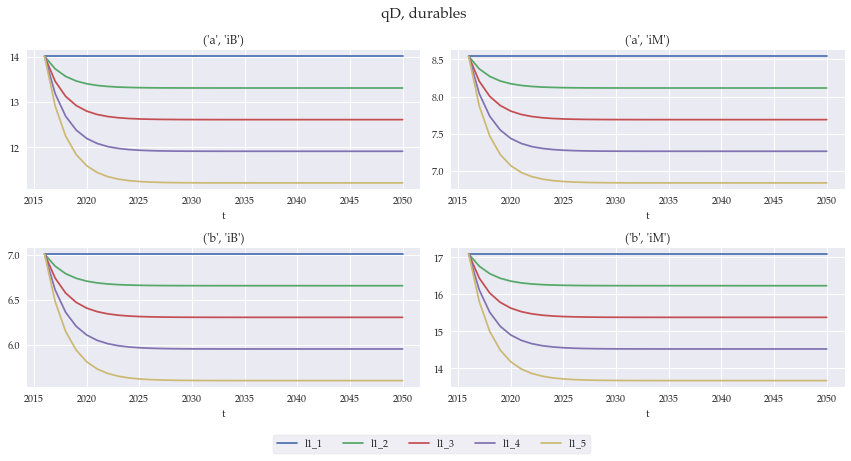

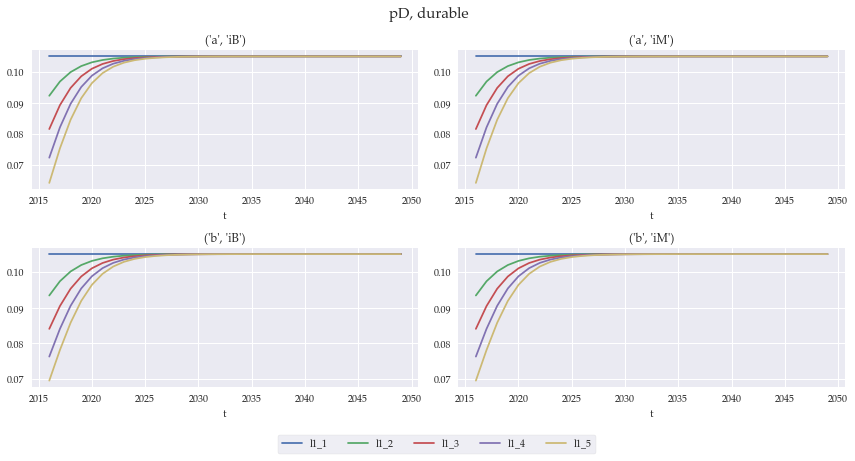

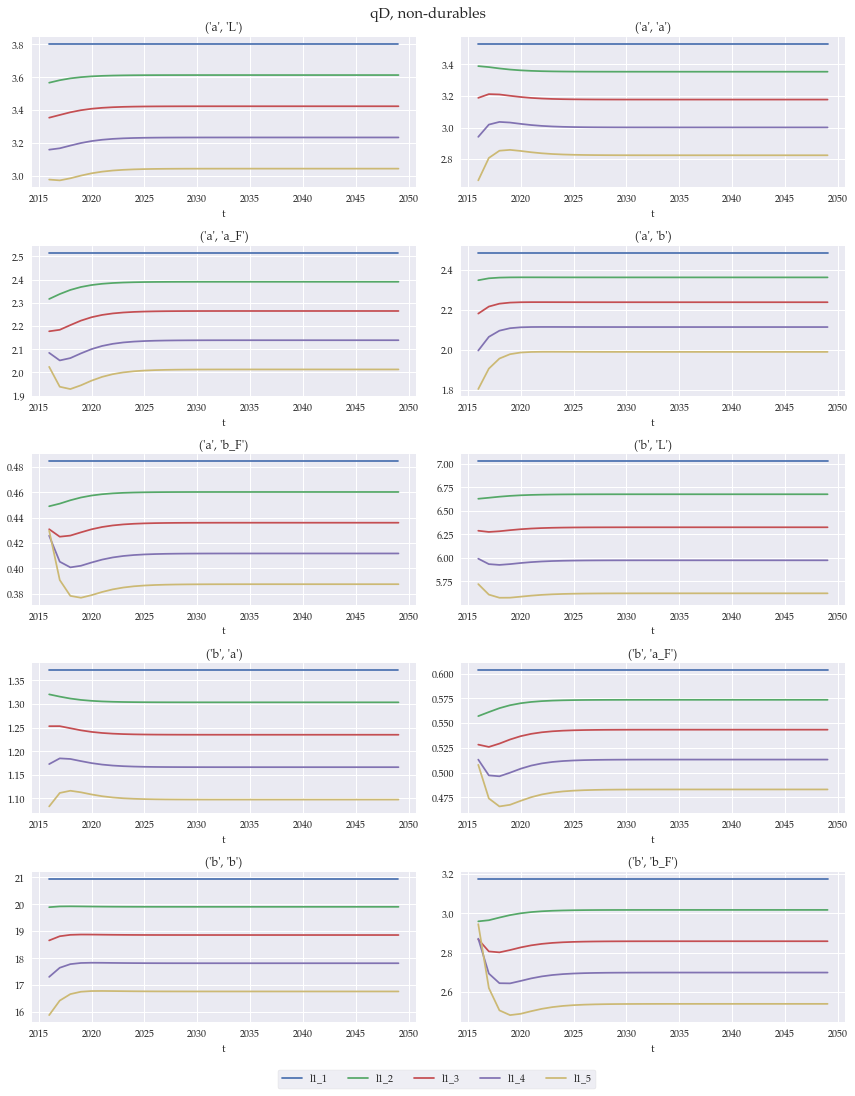

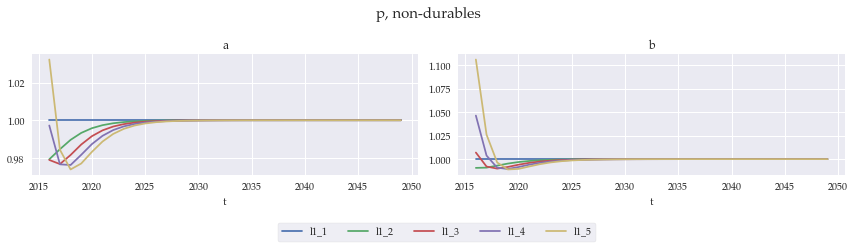

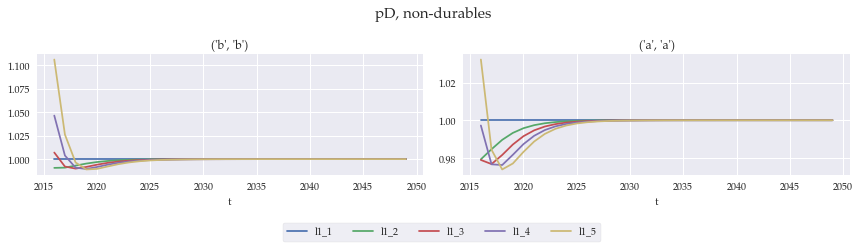

In [20]:
stdPlots(m_s,P)